In [7]:
import pandas as pd
import numpy as np
import mglearn
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
!ls data

item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv


In [9]:
!head data/sales_train.csv

date,date_block_num,shop_id,item_id,item_price,item_cnt_day
02.01.2013,0,59,22154,999.0,1.0
03.01.2013,0,25,2552,899.0,1.0
05.01.2013,0,25,2552,899.0,-1.0
06.01.2013,0,25,2554,1709.05,1.0
15.01.2013,0,25,2555,1099.0,1.0
10.01.2013,0,25,2564,349.0,1.0
02.01.2013,0,25,2565,549.0,1.0
04.01.2013,0,25,2572,239.0,1.0
11.01.2013,0,25,2572,299.0,1.0


In [10]:
sales_train_df = pd.read_csv("data/sales_train.csv", parse_dates=["date"])

In [11]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


# Data manipulations

## Outliers values 

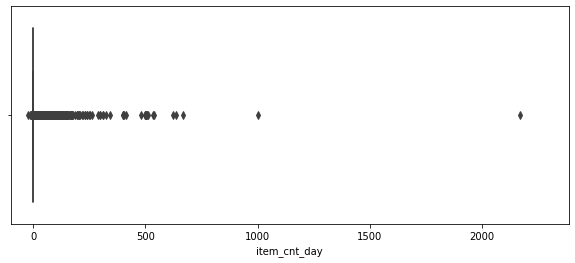

In [12]:
plt.figure(figsize=(10,4))
plt.xlim(-100, sales_train_df.item_cnt_day.max()*1.1)
sns.boxplot(sales_train_df.item_cnt_day)
plt.show()
#sales_train_df.item_price

In [13]:
sales_train_df.item_cnt_day.sort_values()

1057907     -22.0
1835454     -16.0
2048519      -9.0
59156        -6.0
940092       -6.0
            ...  
2608040     624.0
2851091     637.0
2864235     669.0
2326930    1000.0
2909818    2169.0
Name: item_cnt_day, Length: 2935849, dtype: float64

In [14]:
sales_train_df.item_price.sort_values()

484683         -1.0000
608763          0.0700
579766          0.0700
611400          0.0875
673155          0.0900
              ...     
2910156     42990.0000
2327159     49782.0000
1488135     50999.0000
885138      59200.0000
1163158    307980.0000
Name: item_price, Length: 2935849, dtype: float64

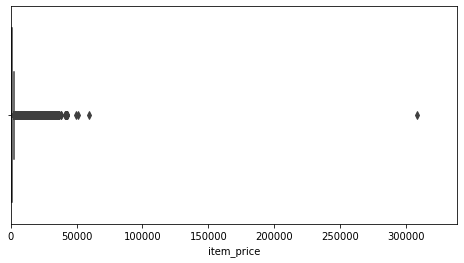

In [15]:
plt.figure(figsize= (8,4))
plt.xlim(sales_train_df.item_price.min()-1, sales_train_df.item_price.max()*1.1)
sns.boxplot(sales_train_df.item_price)
plt.show()

In [16]:
# I'm gonna filter row with item_cnt day > 1000 and price> 60K
# I'm gonna replace negative price

In [17]:
sales_train_df[sales_train_df.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [18]:
sales_train_df.loc[(sales_train_df["item_id"]==2973) & (sales_train_df["shop_id"]==32) & (sales_train_df["item_price"]>0) , "item_price"].mean()

2290.7083333333335

In [19]:
sales_train_df.loc[(sales_train_df["item_price"]<0) , "item_price"] = sales_train_df.loc[(sales_train_df["item_id"]==2973) & (sales_train_df["shop_id"]==32) & (sales_train_df["item_price"]>0) , "item_price"].mean()
sales_train_df = sales_train_df[(sales_train_df["item_price"]<60000) & (sales_train_df["item_cnt_day"]< 1000)]

In [20]:
sales_train_df.shape

(2935846, 6)

## Duplicates values

In [21]:
subset = ['date', 'date_block_num', 'shop_id', 'item_id','item_cnt_day']
sales_train_df.drop_duplicates(subset=subset,keep='first', inplace=True) # 24 duplicate raw removed
#drop_duplicate(sales_train_df, subset = subset)

In [22]:
sales_train_df.shape

(2935822, 6)

##  Adding month aggregated values and other feature

In [23]:
sales_train_df["revenues"] = sales_train_df["item_price"] * sales_train_df["item_cnt_day"]

In [24]:
sales_train_df = sales_train_df.groupby(by=["date_block_num", "shop_id", "item_id"]).agg({"item_cnt_day":"sum", "revenues": "sum"}, axis=1).reset_index()
sales_train_df.rename(columns={"item_cnt_day":"item_cnt_month"}, inplace=True)

In [25]:
sales_train_df.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenues
0,0,0,32,6.0,1326.0
1,0,0,33,3.0,1041.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,257.0


In [26]:
# Non 0 data for month 33 (positive or negative item_cnt_month)
sales_train_df[(sales_train_df["date_block_num"]==33)& (sales_train_df["item_cnt_month"]>0)].shape, sales_train_df[(sales_train_df["date_block_num"]==33)& (sales_train_df["item_cnt_month"]<0)].shape

((31471, 5), (10, 5))

In [27]:
# HERE is what i need to change for kaggle test on month 34
last_month_shoped_items_df = sales_train_df[sales_train_df["date_block_num"]!=33].groupby(by=['shop_id', 'item_id']).agg({'date_block_num':max}).reset_index()
#last_month_shoped_items_df = sales_train_df.groupby(by=['shop_id', 'item_id']).agg({'date_block_num':max}).reset_index()
last_month_shoped_items_df.rename({"date_block_num": "last_shoped_item_month"},axis=1, inplace=True)
last_month_shoped_items_df.last_shoped_item_month.value_counts()

32    29678
31    20267
1     16483
30    15643
23    15576
11    15568
0     15338
2     14655
26    13012
24    12931
5     12261
6     12221
7     12059
3     11858
12    11849
25    11682
29    11233
14    11112
4     11084
8     10861
9     10757
19    10642
10    10472
18    10409
17    10372
21    10228
28    10192
22    10085
13     9984
16     9960
27     9957
15     9665
20     8909
Name: last_shoped_item_month, dtype: int64

## Creating pivot table 

In [28]:
# date_block_num column is going to be pivoted to create on column per possible value (ie one per month_count so from 0 till 33)

In [29]:
pivot_df = sales_train_df.pivot_table(index=["shop_id", "item_id"], columns="date_block_num", values="item_cnt_month", fill_value=0 ,aggfunc='sum').reset_index()
pivot_df.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
pivot_df.shape, pivot_df[pivot_df[33]>0].shape

((424123, 36), (31471, 36))

In [31]:
pivot_df = pivot_df.merge(last_month_shoped_items_df, how="left", on=["shop_id", "item_id"])
#pivot_df.drop(columns='last_shoped_item_month', inplace=True)
#pivot_df.columns = pivot_df.columns.astype(str)
#pivot_df[pivot_df.last_shoped_item_month.isna()]
pivot_df.last_shoped_item_month.fillna(-1, inplace=True)

In [32]:
pivot_df.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,last_shoped_item_month
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [33]:
#def get_tendance_3m(m_30, m_31, m_32 ):
#    x=np.arange(0,3)
#    y=np.array([m_30, m_31, m_32])
#    z = np.polyfit(x,y,1)
#    return z[0]

In [34]:
#pivot_df['tendance_3m'] =pivot_df.apply(lambda x:get_tendance_3m(x[30], x[31], x[32]), axis=1)

In [35]:
#pivot_df[pivot_df['tendance_3m']!=0]

In [36]:
pivot_df.shape

(424123, 37)

# Merging with other dataset

In [37]:
!ls data

item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv


In [38]:
item_df = pd.read_csv("data/items.csv")

In [39]:
shops_df = pd.read_csv("data/shops.csv")

In [40]:
item_cat_df = pd.read_csv("data/item_categories.csv")

In [41]:
item_df = item_df[["item_id","item_category_id"]]
item_df.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [42]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [43]:
shops_df["city"] = shops_df.shop_name.apply(lambda x: x.split(" ")[0])
shops_df.loc[shops_df["city"]=="!Якутск", "city"]='Якутск'
from sklearn.preprocessing import LabelEncoder
shops_df["city_code"] = LabelEncoder().fit_transform(shops_df['city'])

In [44]:
shops_df = shops_df[['shop_id', "city_code"]]

In [45]:
item_cat_df["type"] =item_cat_df.item_category_name.apply(lambda x: x.split(' - ')[0])
item_cat_df["subtype"] =item_cat_df.item_category_name.apply(lambda x: x.split(' - ')[1] if len(x.split(" - "))>1 else "None")
item_cat_df["type_id"] = LabelEncoder().fit_transform(item_cat_df["type"])
item_cat_df["subtype_id"] = LabelEncoder().fit_transform(item_cat_df["subtype"])

In [46]:
item_cat_df = item_cat_df[["item_category_id", 'type_id', "subtype_id"]]

In [47]:
item_cat_df

,item_category_id,type_id,subtype_id
0,0,0,31
1,1,1,12
2,2,1,13
3,3,1,14
4,4,1,16
...,...,...,...
79,79,16,11
80,80,16,28
81,81,17,11
82,82,18,11


In [48]:
pivot_merged_df = pivot_df.merge(item_df, on="item_id", how='left')

In [49]:
item_cat_df.head()

,item_category_id,type_id,subtype_id
0,0,0,31
1,1,1,12
2,2,1,13
3,3,1,14
4,4,1,16


In [50]:
pivot_merged_df = pivot_merged_df.merge(item_cat_df, on="item_category_id", how="left")

In [51]:
pivot_merged_df = pivot_merged_df.merge(shops_df, on='shop_id', how="left")

In [52]:
#pivot_merged_df.drop("shop_name", inplace=True, axis=1)
#pivot_merged_df.drop("city", inplace=True, axis=1)

In [53]:
pivot_merged_df.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,29,30,31,32,33,last_shoped_item_month,item_category_id,type_id,subtype_id,city_code
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,1.0,40,11,6,29
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,1.0,37,11,1,29
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,1.0,40,11,6,29
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,1.0,37,11,1,29
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,1.0,40,11,6,29


In [54]:
pivot_merged_df[pivot_merged_df[33]>0].shape

(31471, 41)

In [55]:
# It could work but i need to change col_name into string type and if I do this then following code not working completeley
#pivot_df.columns = pivot_df.columns.astype(str) to change colomn_name type in string don't change column type
#import os
#os.makedirs('tmp', exist_ok=True)
#df.to_feather('tmp/merged_df-raw')
#pivot_merged_df = pd.read_feather("tmp/merged_df-raw")

In [56]:
#df = pivot_merged_df

In [57]:
pivot_merged_df.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,29,30,31,32,33,last_shoped_item_month,item_category_id,type_id,subtype_id,city_code
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,1.0,40,11,6,29
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,1.0,37,11,1,29
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,1.0,40,11,6,29
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,1.0,37,11,1,29
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,1.0,40,11,6,29


In [58]:
columns = ["shop_id", 'item_id', "last_shoped_item_month", 'type_id', 'subtype_id', "city_code"] + [i for i in  range(34)]
pivot_merged_df = pivot_merged_df[columns]
pivot_merged_df.head()

,shop_id,item_id,last_shoped_item_month,type_id,subtype_id,city_code,0,1,2,3,...,24,25,26,27,28,29,30,31,32,33
0,0,30,1.0,11,6,29,0,31,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,1.0,11,1,29,0,11,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,1.0,11,6,29,6,10,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,1.0,11,1,29,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1.0,11,6,29,1,14,0,0,...,0,0,0,0,0,0,0,0,0,0


#  Modeling

In [59]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

/home/antoine/Documents/Dev/ML/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [60]:
X = pivot_merged_df.drop(columns=[33], axis=1)
y = pivot_merged_df[33]

## How to divide train/ test sets  

In [61]:
pivot_merged_df[pivot_merged_df[33]==0].shape, pivot_merged_df[pivot_merged_df[33]==0].shape[0]/pivot_merged_df.shape[0]*100, pivot_merged_df[pivot_merged_df[33]>0].shape, pivot_merged_df[pivot_merged_df[33]<0].shape

((392642, 40), 92.57738910646204, (31471, 40), (10, 40))

In [62]:
X = pivot_merged_df.drop(columns=[33], axis=1)
y = pivot_merged_df[33]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

In [63]:
X_train.shape, X_test.shape,

((318092, 39), (106031, 39))

In [64]:
sum(y_train==0), sum(y_train==0)/len(y_train) * 100, sum(y_test==0), sum(y_test==0)/len(y_test) * 100

(294586, 92.61031399720837, 98056, 92.47861474474446)

In [65]:
sum(y_train==0)/len(y_train) * 100

92.61031399720837

In [66]:
X = pivot_merged_df.drop(columns=[33], axis=1)
y = pivot_merged_df[33]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 
rf = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10, n_jobs=-1)
rf.fit(X_train, y_train)
rf.score(X_train,y_train), rf.score(X_test, y_test), sum(y_train==0)/len(y_train) * 100

(0.7743886155401644, 0.7683100492232136, 92.56064283289112)

In [67]:
X = pivot_merged_df.drop(columns=[33], axis=1)
y = pivot_merged_df[33]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 
rf = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10, n_jobs=-1)
rf.fit(X_train, y_train)
rf.score(X_train,y_train), rf.score(X_test, y_test), sum(y_train==0)/len(y_train) * 100

(0.8256261187204318, 0.2753521765324545, 92.61031399720837)

In [68]:
sum(y_train==0)/len(y_train) * 100

92.61031399720837

###  Try to add new feature which helps our model

Idea add boolean is_sales_in_last_18_months 

In [69]:
pivot_merged_df.head()

,shop_id,item_id,last_shoped_item_month,type_id,subtype_id,city_code,0,1,2,3,...,24,25,26,27,28,29,30,31,32,33
0,0,30,1.0,11,6,29,0,31,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,1.0,11,1,29,0,11,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,1.0,11,6,29,6,10,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,1.0,11,1,29,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1.0,11,6,29,1,14,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
new_merged_df = pivot_merged_df.copy()
new_merged_df["is_sales_in_last_18_months"] = pivot_merged_df["last_shoped_item_month"]> 14
new_merged_df.head()

,shop_id,item_id,last_shoped_item_month,type_id,subtype_id,city_code,0,1,2,3,...,25,26,27,28,29,30,31,32,33,is_sales_in_last_18_months
0,0,30,1.0,11,6,29,0,31,0,0,...,0,0,0,0,0,0,0,0,0,False
1,0,31,1.0,11,1,29,0,11,0,0,...,0,0,0,0,0,0,0,0,0,False
2,0,32,1.0,11,6,29,6,10,0,0,...,0,0,0,0,0,0,0,0,0,False
3,0,33,1.0,11,1,29,3,3,0,0,...,0,0,0,0,0,0,0,0,0,False
4,0,35,1.0,11,6,29,1,14,0,0,...,0,0,0,0,0,0,0,0,0,False


In [71]:
X = new_merged_df.drop(columns=[33], axis=1)
y = new_merged_df[33]
X_train, X_test , y_train, y_test = train_test_split(X,y, random_state=0)
rf = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [72]:
rf.score(X_train,y_train), rf.score(X_test, y_test)

(0.7722780526649738, 0.7586100791158275)

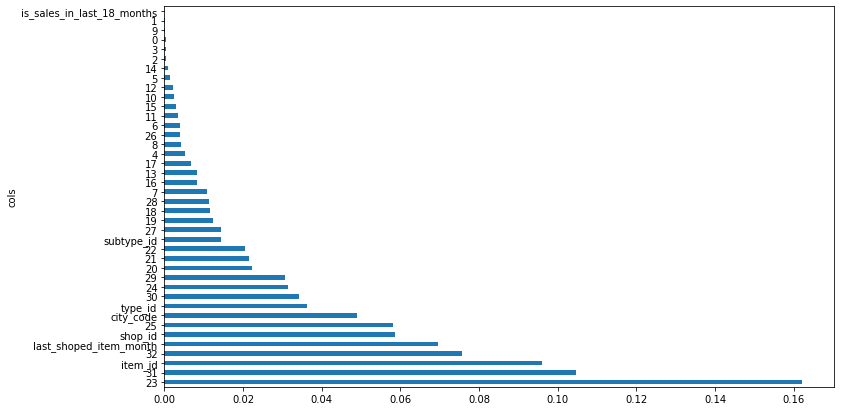

In [73]:
fi = pd.DataFrame({"cols": X_train.columns, "imp": rf.feature_importances_}).sort_values(by="imp", ascending=False)
fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

###  Decrease size of test set 

In [74]:
pivot_merged_df[pivot_merged_df["last_shoped_item_month"]>14].shape

(230441, 40)

In [75]:
data_18_df = pivot_merged_df[pivot_merged_df["last_shoped_item_month"]>14]

In [76]:
X = data_18_df.drop(columns=[33])
y = data_18_df[33]

In [77]:
data_18_df.drop(columns=[33])

,shop_id,item_id,last_shoped_item_month,type_id,subtype_id,city_code,0,1,2,3,...,23,24,25,26,27,28,29,30,31,32
6123,2,27,17.0,5,13,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6124,2,30,16.0,11,6,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6125,2,31,16.0,11,1,0,0,4,1,1,...,0,0,0,0,0,0,0,0,0,0
6126,2,32,31.0,11,6,0,0,0,0,0,...,2,0,0,1,0,0,0,0,1,0
6127,2,33,32.0,11,1,0,1,0,0,0,...,0,0,1,0,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424114,59,22145,20.0,11,1,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424117,59,22153,19.0,11,1,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424120,59,22162,31.0,11,6,30,0,0,0,0,...,0,0,9,4,1,1,0,0,1,0
424121,59,22164,30.0,11,1,30,0,0,0,0,...,0,0,2,1,2,0,0,1,0,0


## Train on all our data

In [78]:
X = pivot_merged_df.drop(columns=[33], axis=1)
y = pivot_merged_df[33]
rf = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10, n_jobs=-1)
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [79]:
X.head()

,shop_id,item_id,last_shoped_item_month,type_id,subtype_id,city_code,0,1,2,3,...,23,24,25,26,27,28,29,30,31,32
0,0,30,1.0,11,6,29,0,31,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,1.0,11,1,29,0,11,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,1.0,11,6,29,6,10,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,1.0,11,1,29,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1.0,11,6,29,1,14,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
rf.score(X,y)

0.8025727669767337

In [81]:
preds = rf.predict(X)

In [82]:
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds, y.values))

In [83]:
rmse

0.8998865320306142

In [84]:
len(X.columns)

39

In [85]:
fi = pd.DataFrame({"cols":X.columns, "imp":rf.feature_importances_}).sort_values(by='imp', ascending=False)
fi.head()

,cols,imp
29,23,0.213100
37,31,0.092899
1,item_id,0.073301
35,29,0.066495
38,32,0.064845


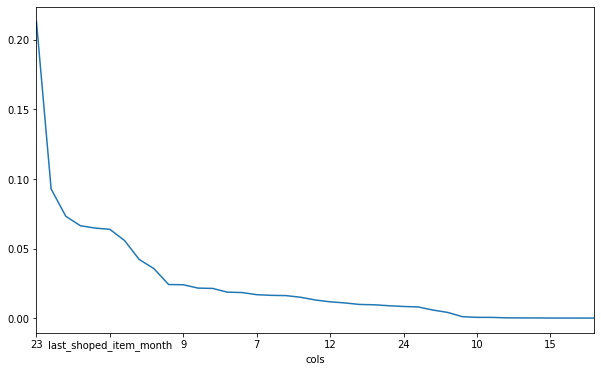

In [86]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

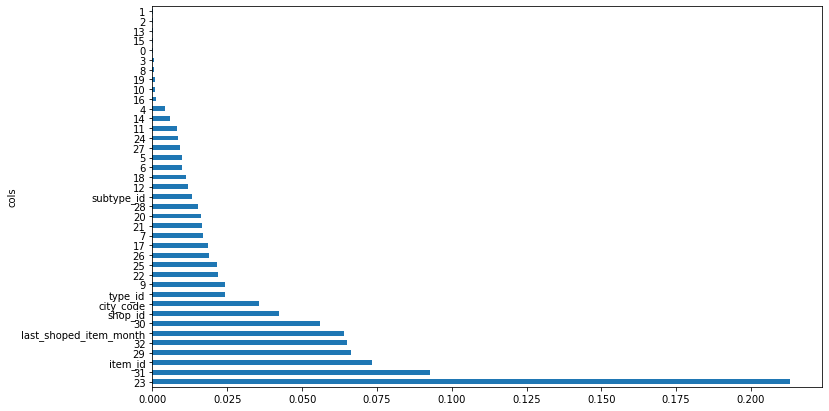

In [87]:
fi[:40].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [88]:
sel_col = fi.loc[fi["imp"]>0.02, "cols"]
sel_col

29                        23
37                        31
1                    item_id
35                        29
38                        32
2     last_shoped_item_month
36                        30
0                    shop_id
5                  city_code
3                    type_id
15                         9
28                        22
31                        25
Name: cols, dtype: object

## Select only important features

In [89]:
X_sel_col = X[sel_col]

In [90]:
rf2 = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10, n_jobs=-1)
rf2.fit(X_sel_col, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [91]:
fi2 = pd.DataFrame({"cols": X_sel_col.columns, "imp":rf2.feature_importances_}).sort_values(by="imp", ascending=False)
fi2

,cols,imp
0,23,0.215489
1,31,0.153002
6,30,0.135623
2,item_id,0.085593
4,32,0.069685
7,shop_id,0.068040
5,last_shoped_item_month,0.060136
11,22,0.047729
3,29,0.047204
8,city_code,0.032184


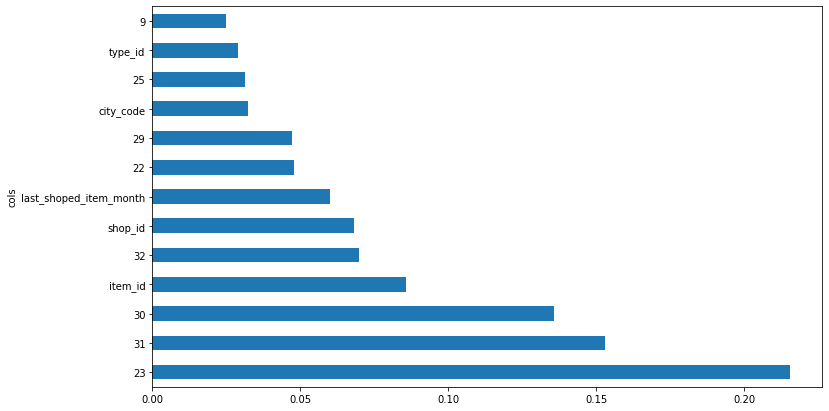

In [92]:
fi2.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [93]:
rf2.score(X_sel_col,y)

0.8035446641456905

# Apply model on kaggle test 

In [94]:
#To test on kaggle data
kaggle_df = pd.read_csv("data/test.csv")
kaggle_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [95]:
kaggle_df = kaggle_df.merge(shops_df, on="shop_id", how='left')
kaggle_df = kaggle_df.merge(item_df, on='item_id', how='left')
kaggle_df = kaggle_df.merge(item_cat_df, on='item_category_id', how="left")
kaggle_df.drop(columns=["item_category_id"], inplace=True)
kaggle_df.head()

,ID,shop_id,item_id,city_code,type_id,subtype_id
0,0,5,5037,3,5,13
1,1,5,5320,3,13,4
2,2,5,5233,3,5,13
3,3,5,5232,3,5,19
4,4,5,5268,3,5,14


In [96]:
#kaggle_df = 
 #TODO normally I should recalculate value of last_shopped_item_month cause value 33 was removed
kaggle_df = kaggle_df.merge(pivot_merged_df, on=['shop_id', 'item_id','city_code', 'type_id', 'subtype_id'], how='left').fillna(0.0)
kaggle_df.head()

,ID,shop_id,item_id,city_code,type_id,subtype_id,last_shoped_item_month,0,1,2,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,3,5,13,32.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,3,13,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,3,5,13,32.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,3,5,19,31.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,3,5,14,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
###################   RECALCULATION OF COLUMN LAST_SHOPED_ITEM_MONTH  to include 33 months sales

In [98]:
new_last_month_shoped_items_df = sales_train_df.groupby(by=['shop_id', 'item_id']).agg({'date_block_num':max}).reset_index()
new_last_month_shoped_items_df.rename({"date_block_num": "last_shoped_item_month"},axis=1, inplace=True)
new_last_month_shoped_items_df.last_shoped_item_month = new_last_month_shoped_items_df.last_shoped_item_month -1
new_last_month_shoped_items_df.head()

,shop_id,item_id,last_shoped_item_month
0,0,30,0
1,0,31,0
2,0,32,0
3,0,33,0
4,0,35,0


In [99]:
kaggle_df_recalculated = kaggle_df.copy()
kaggle_df_recalculated.drop(columns=['last_shoped_item_month'], axis=1, inplace=True)

In [100]:
kaggle_df_recalculated = kaggle_df_recalculated.merge(new_last_month_shoped_items_df, on=["shop_id", "item_id"], how='left')
kaggle_df_recalculated.last_shoped_item_month.fillna(-1, inplace=True)
kaggle_df_recalculated.head()

,ID,shop_id,item_id,city_code,type_id,subtype_id,0,1,2,3,...,25,26,27,28,29,30,31,32,33,last_shoped_item_month
0,0,5,5037,3,5,13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,31.0
1,1,5,5320,3,13,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2,2,5,5233,3,5,13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,32.0
3,3,5,5232,3,5,19,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.0
4,4,5,5268,3,5,14,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0


In [109]:
###############  END OF RECALCULATION
# Result on kaggle show a real decrease with doing it from 1.05 in RMSE to 2.22 
# I don't really understand why we got this

In [101]:
kaggle_col = ["ID"] + columns
kaggle_df = kaggle_df[kaggle_col]
kaggle_df.head()

,ID,shop_id,item_id,last_shoped_item_month,type_id,subtype_id,city_code,0,1,2,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,32.0,5,13,3,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,13,4,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,32.0,5,13,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,31.0,5,19,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,5,14,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
kaggle_df.columns[7:]

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype='object')

In [103]:
d = dict(zip(kaggle_df.columns[7:],list(np.array(list(kaggle_df.columns[7:])) - 1)))
kaggle_df  = kaggle_df.rename(d, axis = 1)
kaggle_df.head()

,ID,shop_id,item_id,last_shoped_item_month,type_id,subtype_id,city_code,-1,0,1,...,23,24,25,26,27,28,29,30,31,32
0,0,5,5037,32.0,5,13,3,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,13,4,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,32.0,5,13,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,31.0,5,19,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,5,14,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
kaggle_df.iloc[:, (kaggle_df.columns != 'ID') & (kaggle_df.columns != -1)]

,shop_id,item_id,last_shoped_item_month,type_id,subtype_id,city_code,0,1,2,3,...,23,24,25,26,27,28,29,30,31,32
0,5,5037,32.0,5,13,3,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,13,4,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,32.0,5,13,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,31.0,5,19,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,5,14,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,26.0,13,4,20,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,45,16188,0.0,14,42,20,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,45,15757,25.0,13,4,20,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,45,19648,0.0,11,6,20,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
preds = rf.predict(kaggle_df.iloc[:, (kaggle_df.columns != 'ID') & (kaggle_df.columns != -1)].values)

In [106]:
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':kaggle_df.ID,'item_cnt_month': preds })
sub_df.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.228912
std,61834.358168,0.879733
min,0.000000,0.006348
25%,53549.750000,0.006348
50%,107099.500000,0.006923
75%,160649.250000,0.136729
max,214199.000000,20.000000


In [107]:
sub_df.head()

,ID,item_cnt_month
0,0,0.594966
1,1,0.006348
2,2,0.583861
3,3,0.228497
4,4,0.006348


In [108]:
sub_df.to_csv('Submission_Predict_Sales2.csv',index=False)

In [ ]:
preds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))

In [118]:
# we want a test set of 100k row with obligatory row which just appeared in month 33 plus some random from which we have historical data previous month 33
X_test_only_33 = pivot_merged_df[pivot_merged_df.last_shoped_item_month.isna()].drop(columns=["33", "item_category_id"], axis=1)
y_test_only_33 = pivot_merged_df[pivot_merged_df.last_shoped_item_month.isna()]["33"]

historical_shop_item_train = merged_df[pivot_merged_df.last_shoped_item_month.isna()==False]
X_train, X_test, y_train, y_test = \
        train_test_split(historical_shop_item_train.drop(columns=['33', "item_category_id"], axis=1), historical_shop_item_train['33'], test_size=93000)


KeyError: "['33' 'item_category_id'] not found in axis"

In [196]:
X_test.shape, X_train.shape, X_test_only_33.shape

((93000, 39), (324003, 39), (7120, 39))

In [197]:
pivot_merged_df.shape

(424123, 41)

In [198]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10, n_jobs=-1)

In [199]:
%time rf.fit(X_train, y_train)

CPU times: user 2min 45s, sys: 545 ms, total: 2min 46s
Wall time: 44 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [200]:
rf.score(X_train, y_train)

0.8186682833279251

In [201]:
rf.score(X_test,y_test)

0.49112831779917376

In [202]:
rf.score(X_test_only_33,y_test_only_33)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [54]:
feat_imp = pd.DataFrame({"col":X_train.columns, "imp":rf.feature_importances_}).sort_values('imp', ascending=False)

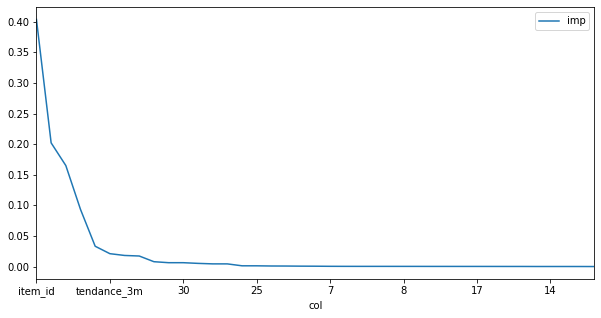

In [55]:
feat_imp.plot("col", "imp", figsize=(10,5))

In [64]:
X_train_restricted = X_train[feat_imp.col[:11].values]
X_test_restricted = X_test[feat_imp.col[:11].values]

In [65]:
rf_2 = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10, n_jobs=-1)

In [67]:
rf_2.fit(X_train_restricted, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [68]:
rf_2.score(X_train_restricted, y_train), rf_2.score(X_test_restricted, y_test)

(0.6557900701020929, 0.3443757320616331)

In [69]:
pd.DataFrame({"col":X_train_restricted.columns, "imp":rf_2.feature_importances_}).sort_values("imp", ascending=False)

,col,imp
0,item_id,0.405987
1,shop_id,0.202716
2,32,0.166785
3,city_code,0.097868
4,subtype_id,0.034260
5,tendance_3m,0.021890
7,31,0.021238
6,type_id,0.019580
8,29,0.012923
10,30,0.008581


In [17]:
from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:forest.check_random_state(rs).randint(0, n_samples, n))
    
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [21]:
set_rf_samples(20000)

In [37]:
reset_rf_samples()

In [38]:
%time rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [39]:
rf.score(X_train, y_train)

NotFittedError: Estimator not fitted, call `fit` before exploiting the model.

In [15]:
%time rf.fit(X_train, y_train)

CPU times: user 8.41 s, sys: 7.94 ms, total: 8.42 s
Wall time: 2.39 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [16]:
rf.score(X_train, y_train)

0.43025052083827464

In [10]:
%prun rf.fit(X_train, y_train)

In [161]:
rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.6252572489613064, 0.40615888270325895)

In [140]:
lr = LinearRegression().fit(X_train, y_train)

In [141]:
lr.score(X_train,y_train), lr.score(X_test, y_test)

(0.0624000432623405, 0.03714431180935984)

In [162]:
svr = SVR().fit(X_train, y_train)

In [163]:
svr.score(X_train, y_train), svr.score(X_test,y_test)

(-0.004945534479543268, -0.006521082793865984)